### Step 1: Data Cleaning and Preprocessing

#### 1. Import Necessary Libraries

In [ ]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sqlalchemy import create_engine

import os

from dotenv import load_dotenv, find_dotenv

In [39]:
px.defaults.template = 'plotly_dark'
px.defaults.color_continuous_scale = px.colors.sequential.Blackbody
px.defaults.width = 800
px.defaults.height = 450

#### 2. Load the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('l4d2_data.csv')

#### 3. Explore the Dataset

In [3]:
# View the first few rows

df.head()

Username  Playtime_(Hours)  Pistol_Shots  Pistol_Kills  Pistol_Usage  \
0         0       2433.577222       94665.0       10470.0          2.77   
1         1        121.879444        9136.0        1371.0          1.47   
2         2         69.955278        4100.0         693.0          4.87   
3         3         48.421667        7369.0        1208.0          5.99   
4         4        307.639722       51944.0        9481.0          8.93   

   Magnum_Shots  Magnum_Kills  Magnum_Usage  Uzi_Shots  Uzi_Kills  ...  \
0      121222.0       27056.0          7.16    44666.0     5165.0  ...   
1       14928.0        6802.0          7.30      997.0      187.0  ...   
2         222.0         133.0          0.93     2834.0      271.0  ...   
3         784.0         250.0          1.24     3322.0      496.0  ...   
4       20545.0        6813.0          6.42    38224.0     5493.0  ...   

   Knife_Usage  Molotovs_Thrown  Molotov_Kills  Pipe_Bombs_Thrown  \
0         0.47          11166.0        99278.0             5817.0   
1         0.03            788.0        10141.0              977.0   
2         0.00             23.0          130.0              445.0   
3         0.00            135.0         1090.0              105.0   
4         0.00            613.0         4797.0              515.0   

   Pipe_Bomb_Kills  Bile_Jars_Thrown  Bile_Jar_Hits  Most_Friendly_Fire  \
0          23433.0            5802.0        12863.0             13653.0   
1           6962.0             519.0         1557.0              1914.0   
2           1202.0              44.0           83.0              3195.0   
3            716.0              48.0           75.0              1412.0   
4           4195.0             272.0          424.0             10851.0   

   Difficulty  Average_Friendly_Fire  
0      Normal                  142.0  
1      Expert                   89.0  
2      Expert                   58.0  
3      Expert                   76.0  
4      Expert                  112.0  

[5 rows x 113 columns]

In [4]:
# Check the dataset's dimensions
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')


The dataset contains 20830 rows and 113 columns.


In [9]:
# Get an overview of the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20830 entries, 0 to 20829
Columns: 113 entries, Username to Average_Friendly_Fire
dtypes: float64(111), int64(1), object(1)
memory usage: 18.0+ MB


In [17]:
df.select_dtypes(include=[object,'int64'])

Username Difficulty
0             0     Normal
1             1     Expert
2             2     Expert
3             3     Expert
4             4     Expert
...         ...        ...
20825     20825     Normal
20826     20826     Normal
20827     20827     Expert
20828     20828   Advanced
20829     20829   Advanced

[20830 rows x 2 columns]

#### 4. Check for Missing Values

In [18]:
# Calculate the number of missing values in each column
missing_values = df.isnull().sum()

# Display columns with missing values
missing_values[missing_values > 0]

Series([], dtype: int64)

Since there are no missing values, we will move on to check if there are any duplicates. 

#### 5. Check for Duplicates

In [19]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

print(f'There are {duplicate_rows.shape[0]} duplicate rows.')


There are 0 duplicate rows.


#### 6. Data Type Conversion

In [20]:
# List of columns expected to be numeric but may not be due to import issues
numeric_columns = df.columns.drop('Difficulty')

# Convert columns to numeric, coerce errors to NaN
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Verify data types
df.dtypes

Username                   int64
Playtime_(Hours)         float64
Pistol_Shots             float64
Pistol_Kills             float64
Pistol_Usage             float64
                          ...   
Bile_Jars_Thrown         float64
Bile_Jar_Hits            float64
Most_Friendly_Fire       float64
Difficulty                object
Average_Friendly_Fire    float64
Length: 113, dtype: object

In [26]:
# After conversion, check for NaNs introduced due to type conversion
df[numeric_columns].isnull().sum()

Username                 0
Playtime_(Hours)         0
Pistol_Shots             0
Pistol_Kills             0
Pistol_Usage             0
                        ..
Pipe_Bomb_Kills          0
Bile_Jars_Thrown         0
Bile_Jar_Hits            0
Most_Friendly_Fire       0
Average_Friendly_Fire    0
Length: 112, dtype: int64

#### 7. Further Cleaning and Feature Engineering

We have some players in the dataset that have no playtime, and a few players that exist only to troll their team. So we will be removing the players that have no playtime and the top 2 worst friendly fire players.

In [99]:
df = df[df['Playtime_(Hours)'] != 0]
df = df[df['Average_Friendly_Fire'] != max(df['Average_Friendly_Fire'])]
df = df[df['Average_Friendly_Fire'] != max(df['Average_Friendly_Fire'])]

In [27]:
# Create Total_Shots and Total_Kills columns
shot_columns = [col for col in df.columns if 'Shots' in col]
kill_columns = [col for col in df.columns if 'Kills' in col]

df['Total_Shots'] = df[shot_columns].sum(axis=1)
df['Total_Kills'] = df[kill_columns].sum(axis=1)


In [29]:
# Calculate Kill Ratio (Kills/Shots) for each weapon
weapon_columns = [col.replace('_Shots', '') for col in shot_columns]

for weapon in weapon_columns:
    shots_col = f'{weapon}_Shots'
    kills_col = f'{weapon}_Kills'
    ratio_col = f'{weapon}_Kill_Ratio'
    df[ratio_col] = df[kills_col] / df[shots_col]
    df[ratio_col] = df[ratio_col].fillna(0)  # Handle division by zero


In [75]:
# List to store all kill ratio columns
kill_ratio_columns = [col for col in df.columns if 'Kill_Ratio' in col]

# Create a boolean mask for infinite values in any kill ratio column
infinite_kill_ratios_mask = df[kill_ratio_columns].applymap(np.isinf)

# Identify rows where any kill ratio is infinite
rows_with_inf_kill_ratios = df[infinite_kill_ratios_mask.any(axis=1)]

# Display the rows with infinite kill ratios
print("Rows with Infinite Kill Ratios:")
print(rows_with_inf_kill_ratios)

/var/folders/23/m666xnxn3yb59qvbhl4ddhk80000gn/T/ipykernel_28981/946007259.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Rows with Infinite Kill Ratios:
       Username  Playtime_(Hours)  Pistol_Shots  Pistol_Kills  Pistol_Usage  \
427         427          1.577778         421.0          54.0         15.34   
6237       6237        124.715000       15093.0        4221.0         11.03   
8408       8408         59.848056       15379.0        2399.0          9.19   
11557     11557         46.502778       10681.0        1267.0          6.61   
12356     12356          0.552778         178.0          85.0         48.02   
13038     13038          8.996389        4206.0         665.0         16.74   
15198     15198          1.015833          40.0           3.0          0.74   
15484     15484         17.999167        2796.0         352.0          6.36   
15825     15825         25.732500        3551.0         453.0          4.02   
18636     18636         15.748333        3171.0         549.0          6.60   
18639     18639          7.536667         980.0         206.0          6.45   
19756     19756     

What I noticed when doing the EDA further down was that for certain columns the kill ratio was coming out to be infinity because they had no data about the shots fired for a particular type of gun and yet they still had kills for those guns. To tackle this, I am going to set all the kill values to zero for all the guns that have no shots fired.

In [76]:
# Iterate through each kill ratio column
for ratio_col in kill_ratio_columns:
    shots_col = ratio_col.replace('_Kill_Ratio', '_Shots')
    # Replace inf kill ratios with zero where shots are zero
    df.loc[df[ratio_col] == np.inf, ratio_col] = 0
    # Additionally, ensure that kills are zero when shots are zero
    df.loc[df[shots_col] == 0, kills_col] = 0

### Step 2: Exploratory Data Analysis (EDA)

#### 1. Descriptive Statistics

In [ ]:
df

Username  Playtime_(Hours)  Pistol_Shots  Pistol_Kills  Pistol_Usage  \
0             0       2433.577222       94665.0       10470.0          2.77   
1             1        121.879444        9136.0        1371.0          1.47   
2             2         69.955278        4100.0         693.0          4.87   
3             3         48.421667        7369.0        1208.0          5.99   
4             4        307.639722       51944.0        9481.0          8.93   
...         ...               ...           ...           ...           ...   
20825     20825         34.481389       10455.0        1494.0         10.70   
20826     20826         19.644722        3834.0         766.0         11.30   
20827     20827         13.125278        3650.0         677.0         10.43   
20828     20828         11.973333        1982.0         239.0          3.62   
20829     20829         31.906667        6104.0         950.0          6.25   

       Magnum_Shots  Magnum_Kills  Magnum_Usage  Uzi_Shots  Uzi_Kills  ...  \
0          121222.0       27056.0          7.16    44666.0     5165.0  ...   
1           14928.0        6802.0          7.30      997.0      187.0  ...   
2             222.0         133.0          0.93     2834.0      271.0  ...   
3             784.0         250.0          1.24     3322.0      496.0  ...   
4           20545.0        6813.0          6.42    38224.0     5493.0  ...   
...             ...           ...           ...        ...        ...  ...   
20825        2738.0         839.0          6.01     4613.0      595.0  ...   
20826        3023.0        1135.0         16.75     1899.0      397.0  ...   
20827         943.0         362.0          5.58     1401.0       85.0  ...   
20828        1423.0         407.0          6.16     2200.0      516.0  ...   
20829        1361.0         495.0          3.26     3686.0      746.0  ...   

       Electric_Guitar_Kill_Ratio  Fire_Axe_Kill_Ratio  Frying_Pan_Kill_Ratio  \
0                        0.543250             0.546954               0.490410   
1                        1.119403             1.232261               0.686275   
2                        0.637255             0.436397               0.657143   
3                        0.431973             0.554140               0.326923   
4                        0.588710             0.580918               0.455538   
...                           ...                  ...                    ...   
20825                    0.153846             0.235294               0.000000   
20826                    0.568182             0.585799               0.047619   
20827                    0.413043             0.515924               0.393939   
20828                    0.333333             0.580071               0.588235   
20829                    0.683673             0.703499               0.500000   

       Katana_Kill_Ratio  Machete_Kill_Ratio  Tonfa_Kill_Ratio  \
0               0.458903            0.483630          0.382067   
1               1.152497            0.969673          0.807183   
2               0.402080            0.444292          0.457143   
3               0.572895            0.585419          0.427632   
4               0.612078            0.487516          0.295191   
...                  ...                 ...               ...   
20825           0.300885            0.571429          0.000000   
20826           0.323580            0.404762          0.000000   
20827           0.486056            0.171429          0.285714   
20828           0.576190            0.000000          0.230769   
20829           0.514851            0.391304          0.562500   

       Golf_Club_Kill_Ratio  Pitchfork_Kill_Ratio  Shovel_Kill_Ratio  \
0                  0.463001              0.265027           0.282805   
1                  0.811060              0.000000           0.600000   
2                  0.265957              0.000000           0.000000   
3                  0.564706              0.000000           0.00000

In [31]:
# Save the cleaned dataset to a new CSV file
df.to_csv('left4dead2_cleaned.csv', index=False)

In [32]:
# Get summary statistics for numeric columns
df.describe()


Username  Playtime_(Hours)   Pistol_Shots   Pistol_Kills  \
count  20830.000000      20830.000000   20830.000000   20830.000000   
mean   10414.500000        104.684003   12389.739558    2031.092127   
std     6013.247389       1974.873029   24198.764272    3944.710074   
min        0.000000          0.000000       0.000000       0.000000   
25%     5207.250000         19.027153    3336.500000     519.000000   
50%    10414.500000         36.110417    6568.000000    1060.000000   
75%    15621.750000         73.698333   12966.750000    2153.000000   
max    20829.000000     277827.960278  608711.000000  131565.000000   

       Pistol_Usage   Magnum_Shots   Magnum_Kills  Magnum_Usage  \
count  20830.000000   20830.000000   20830.000000  20830.000000   
mean       8.035493    4948.215218    1984.546471      5.151902   
std        6.324443   16679.459523    8250.642273      5.586247   
min        0.000000       0.000000       0.000000      0.000000   
25%        4.800000     522.000000     164.000000      1.580000   
50%        6.680000    1462.000000     502.000000      3.540000   
75%        9.470000    3918.000000    1446.000000      6.807500   
max      100.000000  627966.000000  411640.000000    100.000000   

           Uzi_Shots      Uzi_Kills  ...  Electric_Guitar_Kill_Ratio  \
count   20830.000000   20830.000000  ...                20830.000000   
mean     7227.586990    1274.591119  ...                    0.460876   
std     20501.115475    3779.680779  ...                    0.255195   
min         0.000000       0.000000  ...                    0.000000   
25%      1204.000000     195.000000  ...                    0.334540   
50%      2923.500000     506.000000  ...                    0.501258   
75%      6364.250000    1146.750000  ...                    0.623529   
max    731767.000000  152921.000000  ...                    5.884615   

       Fire_Axe_Kill_Ratio  Frying_Pan_Kill_Ratio  Katana_Kill_Ratio  \
count         20830.000000           20830.000000       20830.000000   
mean              0.550149               0.412442           0.510500   
std               0.213101               0.430871           0.176662   
min               0.000000               0.000000           0.000000   
25%               0.487032               0.272727           0.454090   
50%               0.581633               0.450905           0.539367   
75%               0.665286               0.571429           0.614601   
max              13.148148              51.000000           2.268293   

       Machete_Kill_Ratio  Tonfa_Kill_Ratio  Golf_Club_Kill_Ratio  \
count        20830.000000      20830.000000          20830.000000   
mean             0.465173          0.331948              0.340047   
std              0.347415          0.408613              0.326898   
min              0.000000          0.000000              0.000000   
25%              0.395833          0.171282              0.000000   
50%              0.506563          0.359067              0.400000   
75%              0.595907          0.470588              0.557032   
max             39.666667         19.000000             17.000000   

       Pitchfork_Kill_Ratio  Shovel_Kill_Ratio  Knife_Kill_Ratio  
count          20830.000000       20830.000000      20830.000000  
mean               0.049048           0.106109          0.082213  
std                0.160344           0.245599          0.211178  
min                0.000000           0.000000          0.000000  
25%                0.000000           0.000000          0.000000  
50%                0.000000           0.000000          0.000000  
75%                0.000000           0.000000          0.000000  
max                3.661017           3.794118         10.116279  

[8 rows x 148 columns]

#### 2. Distribution of Playtime

In [40]:
fig = px.scatter(x=df['Username'],y=df['Playtime_(Hours)'],
           title='Playtime By User ID',
           color_discrete_sequence=['yellow'],
           labels = {'x':'User ID', 'y':'Hours'})
fig.update_layout(
            hoverlabel=dict(
            bgcolor='blue',
            font_size=16,
            font_family='Arial'))
fig.show()

From our Visualisation we see that there are 2 Users with Playtime that is too high. It might be a data collection issue, so to tackle this we can further clean our dataframe and only include values that have a playtime of less than a total of 1 year. Although 1 year might seem like a lot to cap the playtime for our dataset, it takes into account the fact that L4D2 came out almost 15 years ago, and considering the popularity of the game and the cult following to this day, 1 year can be reachable playtime depending on the recency of when the dataset was collected. 

In [43]:
df = df[df['Playtime_(Hours)'] <= 8760]

In [44]:
fig = px.scatter(x=df['Username'],y=df['Playtime_(Hours)'],
           title='Playtime By User ID',
           color_discrete_sequence=['yellow'],
           labels = {'x':'User ID', 'y':'Hours'})
fig.update_layout(
            hoverlabel=dict(
            bgcolor='blue',
            font_size=16,
            font_family='Arial'))
fig.show()

In [46]:
df.shape

(20828, 149)

As we observe from the graph above and from the shape of the dataframe, there were only 2 outliers that seemed unreasonably high. Since there were only two rows, imputing them was suitable as it doesn't affect the overall data at all. We can still use the data for analysis with the remaining items.

In [103]:
# Sum usage percentages for each weapon
usage_columns = [col for col in df.columns if 'Usage' in col]
weapon_usage = df[usage_columns].mean().sort_values(ascending=False)

# Plot the top 10 weapons
top_weapons = weapon_usage.head(10).reset_index()
top_weapons.columns = ['Weapon', 'Average Usage (%)']

fig = px.bar(
    top_weapons,
    x='Average Usage (%)',
    y='Weapon',
    color_discrete_sequence=['yellow'],
    orientation='h',
    title='Top 10 Weapons by Average Usage Percentage',
    labels={'Average Usage (%)': 'Average Usage (%)', 'Weapon': 'Weapon'},
)

fig.update_layout(yaxis={'categoryorder':'total ascending'})  # To have the highest usage on top
fig.show()


In [104]:
# Extract kill ratio columns
kill_ratio_columns = [col for col in df.columns if 'Kill_Ratio' in col]

# Average kill ratios
average_kill_ratios = df[kill_ratio_columns].mean().sort_values(ascending=False)

# Plot top 10 weapons by kill ratio
top_kill_ratios = average_kill_ratios.head(10).reset_index()
top_kill_ratios.columns = ['Weapon', 'Average Kill Ratio']
fig = px.bar(
    top_kill_ratios,
    x='Average Kill Ratio',
    y='Weapon',
    color_discrete_sequence=['yellow'],
    orientation='h',
    title='Top 10 Weapons by Average Kill Ratio',
    labels={'Average Kill Ratio': 'Average Kill Ratio', 'Weapon': 'Weapon'},
)

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()


In [100]:
# 1. Filter the DataFrame for Average_Friendly_Fire > 1200
threshold = 1200
filtered_df = df[df['Average_Friendly_Fire'] > threshold]

# Check if any players meet the criteria
if filtered_df.empty:
    print(f"No players found with Average_Friendly_Fire > {threshold}.")
else:
    # 2. Prepare the data for plotting
    # Prefix usernames with 'User: '
    filtered_df = filtered_df.copy()  # To avoid SettingWithCopyWarning
    filtered_df['User_Display'] = 'User: ' + filtered_df['Username'].astype(str)
    
    # Sort the DataFrame in descending order of Average_Friendly_Fire
    filtered_df.sort_values(by='Average_Friendly_Fire', ascending=False, inplace=True)
    
    # 3. Create the Plotly bar chart
    fig = px.bar(
        filtered_df,
        x='User_Display',
        y='Average_Friendly_Fire',
        title='Potential Trolls',
        color_discrete_sequence=['yellow'],
        labels={
            'User_Display': 'Usernames',
            'Average_Friendly_Fire': 'Average Friendly Fire'
        }
    )
    
    # 4. Update layout for better aesthetics
    fig.update_layout(
        xaxis={'categoryorder':'total descending'},  # Sort bars from highest to lowest
        hoverlabel=dict(
            bgcolor='blue',
            font_size=16,
            font_family='Arial'
        ),
        title_font_size=24,
        xaxis_tickangle=-45,  # Rotate x-axis labels for better readability
        yaxis_title='Average Friendly Fire',
        xaxis_title='Usernames'
    )
    
    # 5. Enhance hover information and marker aesthetics
    fig.update_traces(
        hovertemplate='<b>%{x}</b><br>Average Friendly Fire: %{y}',
        marker=dict(
            line=dict(width=1, color='DarkSlateGrey')
        )
    )
    
    # 6. Display the figure
    fig.show()

In [118]:
# 1. Calculate average usage for each weapon
weapon_usage_avg = df[usage_columns].mean().reset_index()
weapon_usage_avg.columns = ['Weapon', 'Average Usage (%)']

# 2. Process Weapon Names
# a. Remove the '_Usage' suffix
# b. Replace remaining underscores with spaces
weapon_usage_avg['Weapon'] = weapon_usage_avg['Weapon'] \
    .str.replace('_Usage$', '', regex=True) \
    .str.replace('_', ' ', regex=False)

# Verify the changes
print("Processed Weapon Names:")
print(weapon_usage_avg['Weapon'].head())

# 3. Create the Treemap
fig = px.treemap(
    weapon_usage_avg,
    path=['Weapon'],  # Defines the hierarchy; single level in this case
    values='Average Usage (%)',  # Size of the blocks
    color='Average Usage (%)',  # Color based on usage
    color_continuous_scale=px.colors.sequential.Plasma_r,  # Reverse Plasma color scale
    title='Heatmap of Weapon Usage Patterns',
    labels={'Weapon': 'Weapon'}
)

# Optional: Enhance the treemap's aesthetics
fig.update_traces(
    textinfo='label',  # Display both label and value
    hovertemplate='<b>%{label}</b>'
)

fig.update_layout(
    title={
        'text': 'Heatmap of Weapon Usage Patterns',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin=dict(t=100, l=25, r=25, b=25)  # Adjust margins for better layout
)

# Display the treemap
fig.show()


Processed Weapon Names:
0          Pistol
1          Magnum
2             Uzi
3    Silenced SMG
4             MP5
Name: Weapon, dtype: object


### Step 3: Analysis 

### Player Segmentation and Clustering

#### Objective

Identify distinct player segments based on their in-game behaviors and weapon usage patterns. Understanding different player types can help tailor game features, balance weapons, and personalize player experiences.

In [122]:
# Feature Selection and Engineering

features = [
    'Total_Shots',
    'Total_Kills',
    'Average_Friendly_Fire',
    'Most_Friendly_Fire',
]

# Include Kill Ratio Columns

kill_ratio_columns = [col for col in df.columns if 'Kill_Ratio' in col]
features.extend(kill_ratio_columns)

In [125]:
# Compute the correlation matrix
corr_matrix = df[features].corr().abs()

# Select upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop highly correlated features
X = df[features].drop(columns=high_corr_features)

In [127]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of

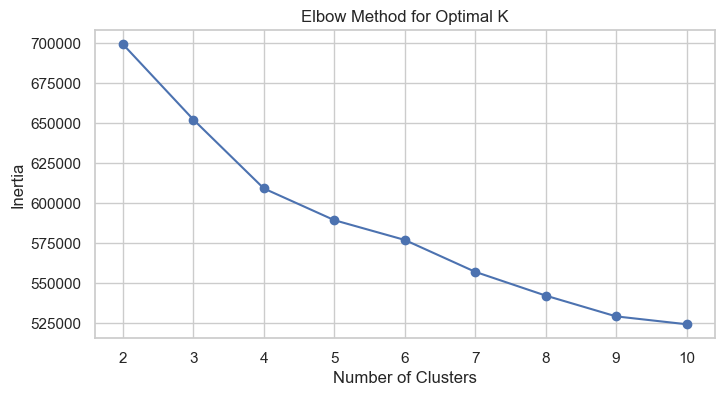

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of

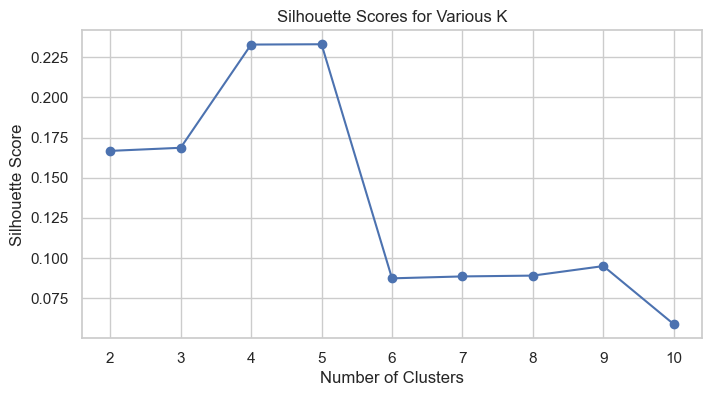

In [ ]:
# Elbow Method
inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

# Silhouette Score

silhouette_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Various K')
plt.show()

In [129]:
# Assuming optimal K is determined to be 4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [130]:
cluster_summary = df.groupby('Cluster')[features].mean()
print(cluster_summary)


           Total_Shots    Total_Kills  Average_Friendly_Fire  \
Cluster                                                        
0         88033.154776   31647.189074              71.647467   
1        251823.092423   98285.067276              93.357936   
2        175989.500000  960891.000000            3482.000000   
3         26914.837489    7974.154591              71.718099   

         Most_Friendly_Fire  Pistol_Kill_Ratio  Magnum_Kill_Ratio  \
Cluster                                                             
0               1352.524168           0.168882           0.363663   
1               4303.706074           0.160349           0.362307   
2              85251.000000           4.128496           0.314944   
3                624.831329           0.174711           0.274559   

         Uzi_Kill_Ratio  Silenced_SMG_Kill_Ratio  MP5_Kill_Ratio  \
Cluster                                                            
0              0.182662                 0.193683        0.031690

In [131]:
# PCA for 2D Visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df['PC1'] = principal_components[:, 0]
df['PC2'] = principal_components[:, 1]

fig = px.scatter(
    df,
    x='PC1',
    y='PC2',
    color='Cluster',
    title='Player Segmentation via PCA and K-Means Clustering',
    labels={'PC1': 'Principal Component 1', 'PC2': 'Principal Component 2'},
    hover_data=['Username']
)

fig.show()


### 2. Weapon Balance and Efficiency Analysis

#### Objective
Assess the balance and efficiency of different weapons based on their usage, kill ratios, and player preferences to inform game balancing decisions.

In [143]:
# 1. Calculate average usage for each weapon
weapon_usage_avg = df[usage_columns].mean().reset_index()
weapon_usage_avg.columns = ['Weapon_Usage', 'Average Usage (%)']

# 2. Calculate average kill ratios for each weapon
kill_ratio_columns = [col for col in df.columns if 'Kill_Ratio' in col]
weapon_kill_ratios = df[kill_ratio_columns].mean().reset_index()
weapon_kill_ratios.columns = ['Weapon_Kill_Ratio', 'Average Kill Ratio']

# 3. Clean Weapon Names in both DataFrames

# Function to clean weapon names
def clean_weapon_name(name, suffix):
    """
    Removes the specified suffix and replaces underscores with spaces.
    
    Parameters:
    - name (str): The original weapon name.
    - suffix (str): The suffix to remove (e.g., '_Usage' or '_Kill_Ratio').
    
    Returns:
    - str: The cleaned weapon name.
    """
    return name.replace(suffix, '').replace('_', ' ')

# Apply cleaning to 'Weapon_Usage' column
weapon_usage_avg['Weapon'] = weapon_usage_avg['Weapon_Usage'].apply(lambda x: clean_weapon_name(x, '_Usage'))

# Apply cleaning to 'Weapon_Kill_Ratio' column
weapon_kill_ratios['Weapon'] = weapon_kill_ratios['Weapon_Kill_Ratio'].apply(lambda x: clean_weapon_name(x, '_Kill_Ratio'))

# 4. Select relevant columns for merging
weapon_usage_avg_clean = weapon_usage_avg[['Weapon', 'Average Usage (%)']]
weapon_kill_ratios_clean = weapon_kill_ratios[['Weapon', 'Average Kill Ratio']]

# 5. Merge the two cleaned DataFrames on 'Weapon'
weapon_analysis = pd.merge(
    weapon_usage_avg_clean,
    weapon_kill_ratios_clean,
    on='Weapon',
    how='inner'  # Ensures only matching weapons are included
)

# 6. Display the merged DataFrame
print(weapon_analysis)

                   Weapon  Average Usage (%)  Average Kill Ratio
0                  Pistol           8.188706            0.168964
1                  Magnum           5.271064            0.348485
2                     Uzi           3.972446            0.187220
3            Silenced SMG           5.175100            0.191899
4                     MP5           0.112777            0.067037
5            Pump Shotgun           2.842151            0.591413
6          Chrome Shotgun           3.561542            0.580642
7        Tactical Shotgun           5.375661            0.445892
8          Combat Shotgun           7.545293            0.446545
9           Assault Rifle           9.770466            0.262551
10           Desert Rifle           5.604202            0.235853
11                  AK-47          12.109438            0.336499
12                 SG-552           0.166080            0.080911
13          Hunting Rifle           2.515428            0.349613
14  Military Sniper Rifle

In [145]:
# Define thresholds (these can be dynamically set based on data distribution)
usage_threshold_high = weapon_analysis['Average Usage (%)'].quantile(0.75)
usage_threshold_low = weapon_analysis['Average Usage (%)'].quantile(0.25)

kill_ratio_threshold_high = weapon_analysis['Average Kill Ratio'].quantile(0.75)
kill_ratio_threshold_low = weapon_analysis['Average Kill Ratio'].quantile(0.25)

# Classify Weapons
def classify_weapon(row):
    if row['Average Usage (%)'] > usage_threshold_high and row['Average Kill Ratio'] < kill_ratio_threshold_high:
        return 'Popular but Inefficient (Buff Needed)'
    elif row['Average Usage (%)'] < usage_threshold_low and row['Average Kill Ratio'] > kill_ratio_threshold_high:
        return 'Underutilized but Efficient (Nerf or Promote)'
    elif row['Average Usage (%)'] > usage_threshold_high and row['Average Kill Ratio'] > kill_ratio_threshold_high:
        return 'Popular and Efficient (Keep Balanced)'
    else:
        return 'Balanced'

weapon_analysis['Weapon_Status'] = weapon_analysis.apply(classify_weapon, axis=1)

print(weapon_analysis)

                   Weapon  Average Usage (%)  Average Kill Ratio  \
0                  Pistol           8.188706            0.168964   
1                  Magnum           5.271064            0.348485   
2                     Uzi           3.972446            0.187220   
3            Silenced SMG           5.175100            0.191899   
4                     MP5           0.112777            0.067037   
5            Pump Shotgun           2.842151            0.591413   
6          Chrome Shotgun           3.561542            0.580642   
7        Tactical Shotgun           5.375661            0.445892   
8          Combat Shotgun           7.545293            0.446545   
9           Assault Rifle           9.770466            0.262551   
10           Desert Rifle           5.604202            0.235853   
11                  AK-47          12.109438            0.336499   
12                 SG-552           0.166080            0.080911   
13          Hunting Rifle           2.515428    

In [158]:
fig = px.scatter(
    weapon_analysis,
    x='Average Usage (%)',
    y='Average Kill Ratio',
    color='Weapon_Status',
    hover_data=['Weapon'],
    title='Weapon Balance Analysis',
    labels={
        'Average Usage (%)': 'Average Usage (%)',
        'Average Kill Ratio': 'Average Kill Ratio'
    },
    color_discrete_map={
        'Popular but Inefficient (Buff Needed)': 'purple',
        'Underutilized but Efficient (Nerf or Promote)': 'lilac',
        'Popular and Efficient (Keep Balanced)': 'green',
        'Balanced': 'yellow'
    }
)

fig.show()


In [156]:
df.head()

Username  Playtime_(Hours)  Pistol_Shots  Pistol_Kills  Pistol_Usage  \
0         0       2433.577222       94665.0       10470.0          2.77   
1         1        121.879444        9136.0        1371.0          1.47   
2         2         69.955278        4100.0         693.0          4.87   
3         3         48.421667        7369.0        1208.0          5.99   
4         4        307.639722       51944.0        9481.0          8.93   

   Magnum_Shots  Magnum_Kills  Magnum_Usage  Uzi_Shots  Uzi_Kills  ...  \
0      121222.0       27056.0          7.16    44666.0     5165.0  ...   
1       14928.0        6802.0          7.30      997.0      187.0  ...   
2         222.0         133.0          0.93     2834.0      271.0  ...   
3         784.0         250.0          1.24     3322.0      496.0  ...   
4       20545.0        6813.0          6.42    38224.0     5493.0  ...   

   Katana_Kill_Ratio  Machete_Kill_Ratio  Tonfa_Kill_Ratio  \
0           0.458903            0.483630          0.382067   
1           1.152497            0.969673          0.807183   
2           0.402080            0.444292          0.457143   
3           0.572895            0.585419          0.427632   
4           0.612078            0.487516          0.295191   

   Golf_Club_Kill_Ratio  Pitchfork_Kill_Ratio  Shovel_Kill_Ratio  \
0              0.463001              0.265027           0.282805   
1              0.811060              0.000000           0.600000   
2              0.265957              0.000000           0.000000   
3              0.564706              0.000000           0.000000   
4              0.440678              0.000000           0.000000   

   Knife_Kill_Ratio  Cluster       PC1       PC2  
0          0.464749        1  1.427082 -3.076122  
1          1.263158        1  7.700521 -1.098945  
2          0.000000        0  0.426137  1.034871  
3          0.000000        0  0.517780  0.034860  
4          0.000000        0  0.067936 -0.208982  

[5 rows x 152 columns]

In [176]:
load_dotenv(find_dotenv())                                                      
                                                  
db_user = os.getenv("DATABASE_USERNAME")                                   
db_password = os.getenv("DATABASE_PASSWORD")                                  
db_host = os.getenv("DATABASE_HOST")                                            
db_port = os.getenv("DATABASE_PORT")                                          
db_database = os.getenv("DATABASE_NAME")                                       
                                                                               
# Construct the database URL
engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_database}')



In [177]:
# Insert data into the SQL database
df.to_sql('gaming_analysis_data', con=engine, if_exists='replace', index=False)



83

In [179]:
# Read data from the database to verify
with engine.connect() as conn:
    result = pd.read_sql('SELECT * FROM gaming_analysis_data', conn)

# Preview the result
print(result.head())

   Username  Playtime_(Hours)  Pistol_Shots  Pistol_Kills  Pistol_Usage  \
0         0       2433.577222       94665.0       10470.0          2.77   
1         1        121.879444        9136.0        1371.0          1.47   
2         2         69.955278        4100.0         693.0          4.87   
3         3         48.421667        7369.0        1208.0          5.99   
4         4        307.639722       51944.0        9481.0          8.93   

   Magnum_Shots  Magnum_Kills  Magnum_Usage  Uzi_Shots  Uzi_Kills  ...  \
0      121222.0       27056.0          7.16    44666.0     5165.0  ...   
1       14928.0        6802.0          7.30      997.0      187.0  ...   
2         222.0         133.0          0.93     2834.0      271.0  ...   
3         784.0         250.0          1.24     3322.0      496.0  ...   
4       20545.0        6813.0          6.42    38224.0     5493.0  ...   

   Katana_Kill_Ratio  Machete_Kill_Ratio  Tonfa_Kill_Ratio  \
0           0.458903            0.483630  